# Chapter 18: Quantum Machine Learning

---

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime import Estimator
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp
from IPython.display import display
from scipy.optimize import minimize
from Chapter18_QML_functions import create_parametric_circuit, pqc_predict_batch,huber_loss, cosine_fidelity_01

from Chapter03_TrussOptimization_functions import (truss2x2, truss3x3,TrussFEM)

## Function to learn, training data and test data

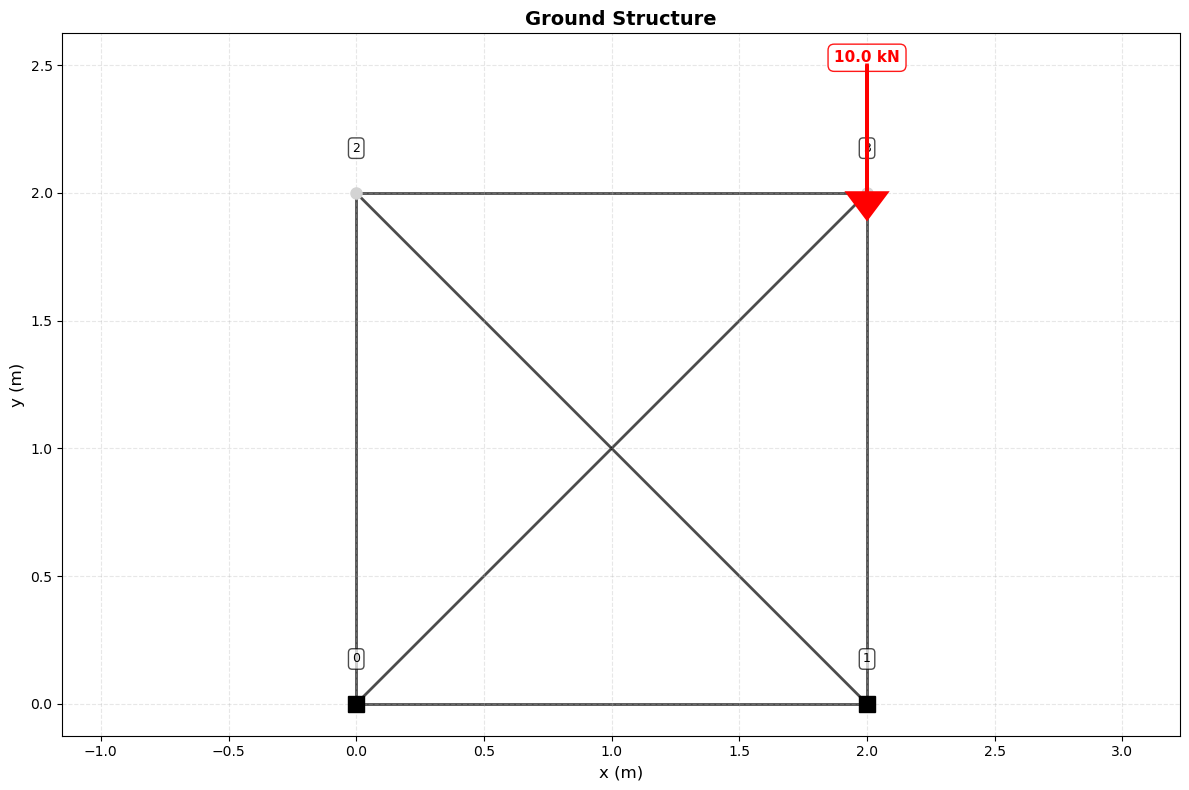

[np.float64(0.9999999999999999), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(1.0), np.float64(0.0), np.float64(7.656854249492379), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(7.656854249492379), np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.8844845978481573), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


In [10]:

example = 2

if (example == 1):
    def tanh_funcion(x):
        return np.tanh(x[0] + 0.5 * x[1])  # Toy function
    function_to_learn = tanh_funcion
    n_train = 30
    n_tests = 10
    n_qubits = 4
    n_layers = 3
    X_train = np.random.uniform(-1, 1, size=(n_train, n_qubits))
    y_train = function_to_learn(X_train.T).T
    X_test = np.random.uniform(-1, 1, size=(n_tests, n_qubits))
    y_test = function_to_learn(X_test.T).T
elif (example == 2): # truss design
    fem_model, loads, fixed_dofs, design_full = truss2x2()

    n_qubits = len(design_full)
    n_layers = 3
    fem_model.plot_truss(loads=loads, fixed_dofs=fixed_dofs, show_labels=True,title="Ground Structure")
    
    def trussCompliance(x):
        d, valid = fem_model.solve(x, loads, fixed_dofs)
        compliance = loads.T @ d
        return compliance

    n_train = 30
    n_tests = 10
    X_train = np.random.choice([0, 1], size=(n_train, n_qubits))
    y_train = []
    for i in range(n_train):
        design = X_train[i,:]  # Single design (1D array)
        compliance = trussCompliance(design)
        y_train.append(compliance)
    print(y_train)
    X_test = np.random.choice([0, 1], size=(n_tests, n_qubits))
    y_test = []
    for i in range(n_tests):
        design = X_test[i,:]  # Single design (1D array)
        compliance = trussCompliance(design)
        y_test.append(compliance)
else:
    raise("Not implemented")


## Parameterized QC

In [3]:
np.random.seed(42) 

qc = create_parametric_circuit(n_qubits, n_layers)
observable = SparsePauliOp.from_list([("Z" + "I" * (n_qubits - 1), 1.0)])
#display(qc.draw('mpl'))

## Simulator, loss function

In [7]:
nShots = 5000
backend = Aer.get_backend("qasm_simulator") 
estimator = Estimator(backend, options={"default_shots": nShots})

def loss_theta(theta_vec):
    preds = pqc_predict_batch(theta_vec, X_train, qc, observable, estimator)
    return huber_loss(preds, y_train)


## Training

In [8]:
theta0 = np.random.normal(0, 0.1, size=n_layers * n_qubits * 3)
res = minimize(
    loss_theta,
    theta0,
    method="COBYLA",
    options={"maxiter": 100}
)

theta_star = res.x
print("Training done.")
print("Final loss:", loss_theta(theta_star))


Training done.
Final loss: 0.027683681290296476


## Check fidelity using test data 

In [9]:
preds = pqc_predict_batch(theta_star, X_test, qc, observable, estimator)
print("First 5 preds:", preds[:5])
print("First 5 y:", y_test[:5])

print("Cosine fidelity (train):", cosine_fidelity_01(preds, y_test))

First 5 preds: [ 0.0124  0.0232  0.0172 -0.0136 -0.0012]
First 5 y: [np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0)]
Cosine fidelity (train): 0.45045652157118155
